# Character Classification

### A cell to import all the modules

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Scikit-learn functions
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


The task comprises of 3 sub-tasks and I will attempt to go through them one by one in this notebook.

## 1. SUBTASK - 1

To train a CNN with random initial weights on the dataset given for character `0-9`, `A-Z` and `a-z`. The tasks asks specifically to not use any other data-source or pretrained network which is new since fine-tuning a deep-net to a specific dataset is usually an easier and preferred approach these-days.

#### So the first step of this task is to visualze the data-distribution

Assuming that the unziped data-folder is present where the notebook is located. We can unzip the `.zip` folder using python if required.

Number of classes in the dataset are 62
Total number of images in the dataset is 2480


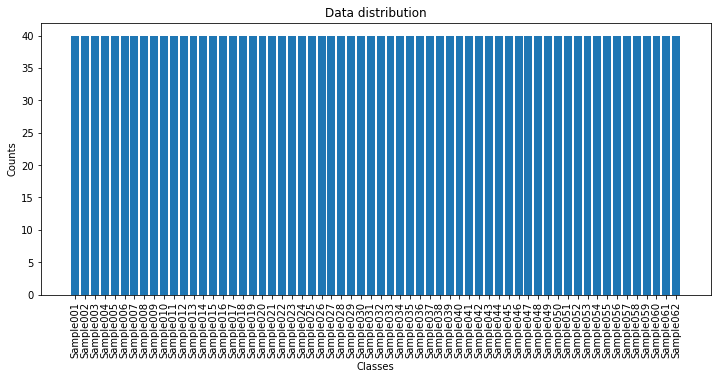

In [ ]:
# path variables
root_dir = './train'
classes = os.listdir(root_dir)

print(f'Number of classes in the dataset are {len(classes)}')

counts = []
for class_ in classes:
    counts.append(len(os.listdir(os.path.join(root_dir, class_))))
                  
print(f'Total number of images in the dataset is {sum(counts)}')

plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=85)
plt.title('Data distribution')

plt.show()

#### Visualizing all the classes

Shape of the images are (900, 1200, 3)


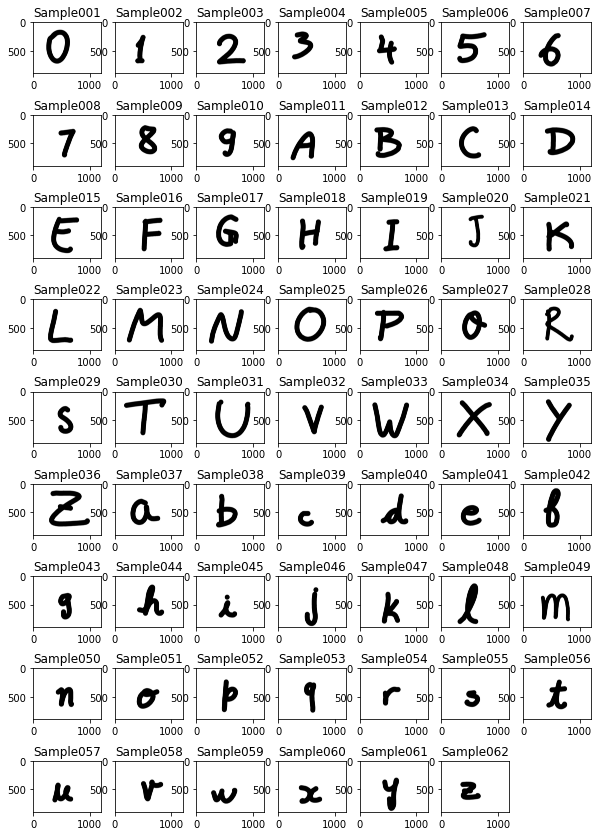

In [ ]:
imgs = []
for class_ in classes:
    # one-image from each class for visualization 
    imgs.append(os.path.join(root_dir, class_,
                             os.listdir(os.path.join(root_dir, class_))[0]))
    
fig=plt.figure(figsize=(10, 15))
columns = 7
rows = int(len(imgs)/columns)+1
print(f'Shape of the images are {np.shape(cv2.imread(imgs[0]))}')

for i in range(len(imgs)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(cv2.imread(imgs[i]))
    plt.title(classes[i])
plt.show()

These images are *1200 $\times$ 900 pixels* in size, which is big. Since I have to use MNIST dataset for the later sub-tasks and the images in that dataset are *28 $\times$ 28* pixels I will downscale the images to *28 $\times$ 28*.

#### Possibly confusing classes: 
1. `O`, `o`, `0` and `Q` all look very similar and are consufing.
2. `g`, `9` and `q` is often confusing for humans to distingwish is well.
3. `G` and `6`; `B` and `8` are some other confusing classes. 
4. `C` and `c`; `K` and `k`; `P` and `p`; `S` and `s` can be confusing is well as they only differ in size. (zoom-augmention possibly not a good choice).

We can see that the data is evenly distributed amoong all the `62 classes`. Although the number of images is nowhere near enough to train a deep-net the problem itself is not complicated enough to be requiring a deep net. Therefor I will be defining a shallow network architecture which in my assumption is more suitable for the problem. A model in general has a lot of hypermaters as shown in the image. I will not tune **spacial-feature** paramters because of the fact that NN in general should be able to approxiate any function. We will just assume a CNN arcitecture and work on training it.

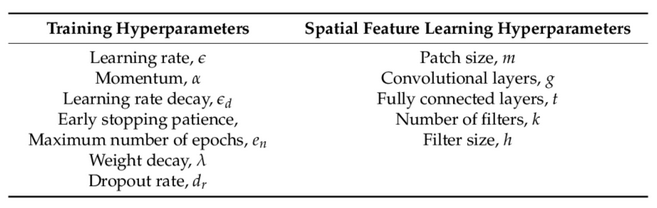

***source***: [Overview of CNN hyperparameters](https://www.researchgate.net/figure/Overview-of-CNN-hyperparameters_tbl2_320723116)


#### Defining a class for all the redundant tasks (Class is defined in  the cell below)

This will help in keeping the notebook clean to read as it will have lesser lines of codes

In [ ]:
class MIDAS_CNN:
    def __init__(self):
        self.model = None

    # A function to define and compile the CNN
    def compile_CNN(self, MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR,
                    MOMENTUM=0.9, label_smoothing=0.1, og_model=None):
        '''
            MODEL_INPUT_SIZE: (CNN)model input size
            N_CLASSES: number of classes in the final layer
            INITIAL_LR: initial learning rate of the optimizer (optional)
            MOMENTUM: momentum of the SGD optimizer (optional)
            label_smoothing: learning rate of the optimizer (optional)
            og_model: original model to transfer learn from (optional)
        '''
        try:
            self.MODEL_INPUT_SIZE = MODEL_INPUT_SIZE
            self.N_CLASSES = N_CLASSES
            self.INITIAL_LR = INITIAL_LR

            if og_model is None:
                # Defining the model
                self.model = Sequential()  # add model layers
                # Layer 1
                self.model.add(Conv2D(8, (3, 3), input_shape=self.MODEL_INPUT_SIZE))
                # define the activaion function for this layer
                self.model.add(Activation('relu'))
                # define the pooling for this layer
                self.model.add(MaxPool2D(pool_size=(2, 2)))

                # Layer 2
                self.model.add(Conv2D(16, (3, 3)))
                # define the activaion function for this layer
                self.model.add(Activation('relu'))
                # define the pooling for this layer
                self.model.add(MaxPool2D(pool_size=(5, 5)))

                # Flattening
                self.model.add(Flatten())
                # Dropout
                self.model.add(Dropout(0.5, name='final_dropout'))  # - for regularization

                # Final output layer
                self.model.add(Dense(N_CLASSES, activation='softmax',
                                     name='classification', dtype='float32'))
                self.model.compile(optimizer=SGD(learning_rate=INITIAL_LR,
                                                 momentum=MOMENTUM, nesterov=True),
                                   loss=CategoricalCrossentropy(label_smoothing=label_smoothing),
                                   metrics=['accuracy'])
                self.model.summary()
                return None
            else:
                og_model.layers.pop()
                outputs = Dense(N_CLASSES, activation="softmax",
                                name="classification", dtype='float32')(og_model.layers[-2].output)
                self.model = Model(inputs=og_model.inputs, outputs=outputs)
                print('Original Model Transformed successfully')
                self.model.compile(optimizer=SGD(learning_rate=INITIAL_LR,
                                                 momentum=MOMENTUM, nesterov=True),
                                   loss=CategoricalCrossentropy(label_smoothing=label_smoothing),
                                   metrics=['accuracy'])
                self.model.summary()
                return None
        except:
            print('Error in compiling the CNN')
            return None

    # A function to define the data-generators
    def define_generators(self, BATCH_SIZE, df, x_col='imgs', y_col='label',
                          stratify=True, VALIDATION_SPLIT=0.1):
        '''
             BATCH_SIZE: batch size of the generators
             df: dataframw with all the images and labels
             x_col: name of the column with image name (optional)
             y_col: name of the column with the image label (optional)
             stratify: to make a stratified split (optional)
             VALIDATION_SPLIT: percentage of data to be used for validation (optinal)
        '''
        try:
            self.BATCH_SIZE = BATCH_SIZE
            self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]

            if stratify:

                df_train, df_validation = train_test_split(df, test_size=VALIDATION_SPLIT, random_state=2021,
                                                           stratify=df[y_col].values.tolist())
            else:
                df_train, df_validation = train_test_split(df, test_size=VALIDATION_SPLIT, random_state=2021)
            # Setting a seed to get the same split everytime

            # Augmenting the train generator
            data_generator = ImageDataGenerator(
                rotation_range=10,  # in degrees
                width_shift_range=0.05,  # <1 shift left or right
                height_shift_range=0.05,  # <1 shift up or down
                zoom_range=[0.9, 1.1],  # zooming range
                rescale=1. / 255,  # rescale the images to be float in range [0, 1]
            )

            self.train_generator = data_generator.flow_from_dataframe(
                dataframe=df_train,
                x_col=x_col,  # column with image path
                y_col=y_col,  # column with label
                target_size=self.INPUT_SIZE,
                batch_size=self.BATCH_SIZE,
                color_mode='grayscale',
                class_mode='categorical',
                shuffle=True,
                seed=2021,  # seeting the seed for shuffling and transformation
            )

            # Not augmenting the validation generator
            data_generator = ImageDataGenerator(
                rescale=1. / 255,  # rescale the images to be float in range [0, 1]
            )

            self.validation_generator = data_generator.flow_from_dataframe(
                dataframe=df_validation,
                x_col=x_col,  # column with image path
                y_col=y_col,  # column with label
                target_size=self.INPUT_SIZE,
                batch_size=self.BATCH_SIZE,
                color_mode='grayscale',
                class_mode='categorical',
                shuffle=False,
            )
            return None
        except:
            print('Error in defining generators')
            return None

    # A function to define the callbacks
    def define_callbacks(self, ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME,
                         LR_REDUCTION_FACTOR=0.2, MODEL_LOC='./models'):
        '''
            ES_PATIENCE: patience for early stopping
            LR_PATIENCE: patience to reduce learning-rate
            MODEL_WTS_FILE_NAME: weights .h5 filename
            LR_REDUCTION_FACTOR: factor to reduce the learning rate by (optinal)
            MODEL_LOC: location to save models in (optional)
        '''
        try:
            if not os.path.exists(MODEL_LOC):
                os.mkdir(MODEL_LOC)
            # Defining callbacks
            self.MODEL_LOC = MODEL_LOC
            self.MODEL_WTS_FILE_NAME = MODEL_WTS_FILE_NAME
            es_callback = EarlyStopping(
                monitor='val_accuracy',
                patience=ES_PATIENCE,
                mode='max'
            )  # only stopping if model's validation accuracy has saturated/peaked

            reduce_lr_callback = ReduceLROnPlateau(
                monitor='val_loss',
                patience=LR_PATIENCE, verbose=1,
                factor=LR_REDUCTION_FACTOR
            )  # reducing learning rate if validation loss doesn't deacrease

            mc_callback = ModelCheckpoint(
                filepath=os.path.join(self.MODEL_LOC, self.MODEL_WTS_FILE_NAME),
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )  # saving the best model based on accuracy on validation dataset

            # Defining callbacks for saving model checkpoints and early stopping
            self.callbacks = [es_callback, mc_callback, reduce_lr_callback]
            return None
        except:
            print('Error in defining callbacks')
            return None

    # A function to train the defined model
    def train(self, EPOCHS=100):
        '''
            EPOCHS: epochs to train the model for
        '''
        try:
            self.train_history = self.model.fit(
                self.train_generator,
                steps_per_epoch=self.train_generator.samples // self.BATCH_SIZE,
                validation_data=self.validation_generator,
                validation_steps=self.validation_generator.samples // self.BATCH_SIZE,
                epochs=EPOCHS, verbose=1, callbacks=self.callbacks
            )
            return None
        except:
            print('Error in training model')
            return None

    # A function to train given X and Y for MNIST
    def train_x_y(self, x_train, y_train,
                  BATCH_SIZE, EPOCHS, VALIDATION_SPLIT):
        '''
            x_train: training data
            y_train: testing data
            BATCH_SIZE: batch size for training and validation
            EPOCHS: epochs for training
            VALIDATION_SPLIT: percentage of data to be used for validation
        '''
        try:
            self.BATCH_SIZE = BATCH_SIZE
            self.train_history = self.model.fit(
                x_train, y_train,
                batch_size=self.BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=VALIDATION_SPLIT,
                callbacks=self.callbacks
            )
            return None
        except:
            print('Error in training model')
            return None

    # A function to plot training history
    def training_history(self, title='training history'):
        '''
            title: title of the plot (optional)
        '''
        try:
            fig = plt.figure(1, figsize=(15, 7))
            axes = fig.add_subplot(1, 2, 1)
            axes.plot(self.train_history.history['accuracy'], color='C0')
            axes.plot(self.train_history.history['val_accuracy'], color='C1')
            axes.set(xlabel='Epochs', ylabel='Accuracy', title='Model Accuracy')
            axes.legend(['train accuracy', 'validation accuracy'])

            axes = fig.add_subplot(1, 2, 2)
            axes.plot(self.train_history.history['loss'], color='C0')
            axes.plot(self.train_history.history['val_loss'], color='C1')
            axes.set(xlabel='Epochs', ylabel='Loss', title='Model Loss')
            axes.legend(['train loss', 'validation loss'])
            plt.suptitle('MIDAS CNN - OG(scratch) training history')
            plt.show()
            return None
        except:
            print('Error in plotting history of the model')
            return None

    # A function plot confusion matrix
    def analyze_model(self, figsize=(10, 7)):
        '''
            figuresize: size of plot (optional)
        '''
        try:
            probabilities = self.model.predict(self.validation_generator, len(self.validation_generator))
            prediction_label = np.argmax(probabilities, axis=1)
            val_labels = self.validation_generator.classes

            print('Class labels')
            print(self.validation_generator.class_indices)
            print('\n')

            print('Class distribution in validation set')
            n_class, n_count = np.unique(val_labels, return_counts=True)
            count_dict = {}
            for n_class_, n_count_ in zip(n_class, n_count):
                count_dict[n_class_] = n_count_
            print(f'{count_dict}')
            print('\n')

            classes = self.validation_generator.class_indices.keys()
            # Plotting confusion matrix
            cm = confusion_matrix(prediction_label, val_labels)
            df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
            fig, ax = plt.subplots(figsize=figsize)  # Sample figsize in inches
            sns.heatmap(df_cm, annot=True, ax=ax)
            plt.xlabel('True Labels')
            plt.ylabel('Predicted Labels')
            plt.title('Validation Confusion Matrix')
            acc = ((prediction_label == val_labels).sum()) / len(val_labels) * 100
            print('Validation Accuracy of the model is %.2f%%' % (acc))
            plt.show()
            return None
        except:
            print('Error in analyzing the model')
            return None

    # A function to make test prediction and plot confusion matrix
    def analyse_x_y(self, x_test, y_test, figsize=(10, 7)):
        '''
            x_test: test data
            y_test: test label
            figsize: size of the plot (optional)
        '''
        try:
            probabilities = self.model.predict(x_test)
            prediction_label = np.argmax(probabilities, axis=1)
            val_labels = np.argmax(y_test, axis=1)

            print('Class distribution in MNIST test set')
            n_class, n_count = np.unique(val_labels, return_counts=True)
            count_dict = {}
            for n_class_, n_count_ in zip(n_class, n_count):
                count_dict[n_class_] = n_count_
            print(f'{count_dict}')
            print('\n')

            classes = np.unique(val_labels)
            classes.sort()
            # Plotting confusion matrix
            cm = confusion_matrix(prediction_label, val_labels)
            df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
            fig, ax = plt.subplots(figsize=figsize)  # Sample figsize in inches
            sns.heatmap(df_cm, annot=True, ax=ax)
            plt.xlabel('True Labels')
            plt.ylabel('Predicted Labels')
            plt.title('Test Confusion Matrix')
            acc = ((prediction_label == val_labels).sum()) / len(val_labels) * 100
            print('Test Accuracy of the model is %.2f%%' % (acc))
            plt.show()
        except:
            print('Error in analyzing the model')
            return None

    # A function to return the trained model
    def return_model(self):
        return self.model

    # A function to return training history
    def return_training_history(self):
        return self.train_history

    # A function to load the trained model
    def load_model(self, model_loc=None):
        '''
            model_loc: location of the .h5 file to load weights from
        '''
        try:
            if model_loc is not None:
                self.model.load_weights(model_loc)
            else:
                self.model.load_weights(os.path.join(self.MODEL_LOC, self.MODEL_WTS_FILE_NAME))
            return None
        except:
            print('Error in loading weights for the model')
            return None

    # A function to make prediction
    def predict_img(self, img_loc):
        '''
        INPUT ->
            img_loc: Takes in location of an image
        OUTPUT ->
            prediction-probabilit, prediction-label
        '''
        self.img_sz = self.MODEL_INPUT_SIZE[0]
        try:
            if os.path.exists(img_loc):
                try:
                    img = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
                    # rescaling image
                    img = cv2.resize(img, dsize=(self.img_sz, self.img_sz),
                                     interpolation=cv2.INTER_AREA)
                    plt.imshow(img)
                    img = img / 255
                    img = img.reshape(1, self.img_sz, self.img_sz, 1)
                except:
                    print('Unable to load image')
                    return None, None
                # load the model before calling this function

                print(np.shape(img))
                prediction_prob = self.model.predict(img)
                prediction_label = np.argmax(prediction_prob, axis=1)
                return prediction_prob[0], prediction_label[0]
            else:
                print(f'No image found with path {img_loc}.')
                return None, None
        except:
            print('Error in predicting for an image')
            return None, None

    # A function to define a batch for data-format
    # similar to the training data for testing
    def test_format1(self, test_data_loc, BATCH_SIZE=16):
        self.BATCH_SIZE = BATCH_SIZE
        self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]
        # Not augmenting the test generator
        data_generator = ImageDataGenerator(
            rescale=1. / 255,  # rescale the images to be float in range [0, 1]
        )
        test_generator = data_generator.flow_from_directory(
            directory=test_data_loc,
            target_size=self.INPUT_SIZE,
            batch_size=self.BATCH_SIZE,
            color_mode='grayscale',
            class_mode='categorical',
            shuffle=False,
        )

        # Predict in the test-data make sure that you have loaded the model
        prediction_probs = self.model.predict_generator(test_generator)
        prediction_labels = np.argmax(prediction_probs, axis=1)
        test_labels = test_generator.classes
        
        print('Class labels')
        print(test_generator.class_indices)
        classes = test_generator.class_indices.keys()
        print('\n')
        # Plotting confusion matrix
        acc = self.analyse_test_set(prediction_labels, test_labels, classes)
        return acc
        
        
    #  A function to define a batch for data-format
    # similar to kaggle to generate predictions.csv
    def test_format2(self, test_data_loc, BATCH_SIZE=16):
        self.BATCH_SIZE = BATCH_SIZE
        self.INPUT_SIZE = self.MODEL_INPUT_SIZE[:2]
        images = os.listdir(test_data_loc)
        df = pd.DataFrame()
        df['image'] = images
        df['dummy_class'] = ['' for image in images]
        data_generator = ImageDataGenerator(
            rescale=1. / 255,  # rescale the images to be float in range [0, 1]
        )
        test_generator = data_generator.flow_from_dataframe(
            df,
            directory=test_data_loc,
            x_col='image',
            y_col='dummy_class',
            target_size = self.INPUT_SIZE,
            batch_size = self.BATCH_SIZE,
            color_mode = 'grayscale',
            class_mode = None,
            shuffle = False,
        )
        prediction_probs = self.model.predict_generator(test_generator)
        prediction_labels = np.argmax(prediction_probs, axis=1)
        df.drop(['image', 'dummy_class'], axis=1)
        df['image'] = list(test_generator.filenames)
        df['probability'] = list(prediction_probs)
        df['label'] = list(prediction_labels)
        return df

    def analyse_test_set(self, predictions, labels, classes):
        # Plotting confusion matrix
        cm = confusion_matrix(predictions, labels)
        df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
        plt.figure(figsize=(20, 15))
        plt.title('Test Confusion Matrix')
        sns.heatmap(df_cm, annot=True)
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')

        acc = ((predictions == labels).sum()) / len(labels) * 100
        print('Test Accuracy of the model is %.2f%%' % (acc))
        plt.show()
        return acc

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

In [ ]:
N_CLASSES = len(classes)
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-1.h5'
ES_PATIENCE = 20 # patience for early-stopping (in epochs)
'''
using a high early stopping crierion as the model is trained
from scratch and we do not want it to stop early
'''
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=200

Defining and compiling model-1 for training

#### Defining the model & generators (to load the images in batches for training)

First defining some basic parameters and then defining a small model with less number of parametrs because theoretically, a simple two-layer neural network with **2n+d parameters** is capable of perfectly fitting any dataset of **n samples** of **dimension d** ([Zhang et al., 2017](https://arxiv.org/abs/1611.03530)). So to answer your question, having such a large model can lead to overfitting. 

We have **~2000** samples to learn from (after using `10%` of `2480 data-points` for validation). So our **n is 2232** and our **d is 28$\times$28 = 784** *(input-size)*, thus to be able to not overfit and train a model from scratch we should have **< 5248(~5000)** parameters in the network which will needs to be a small network which fairly less number of features in the `flat layer`. If we want to define more layers then we must add regularization of some sort to avoide overfitting (since this number of allowed parameters to avoide overfitting is way too less I will use **Dropout** regularization). In addition I will have some data-augmentations to generate artificical (sudo) data-points, these factors will allow me to have parameters in CNN and still avoide overfitting.

Adding higher label-smmothing (default label-smmothing 0.1 for MIDAS-CNN) to the model-loss because of the possibel confusion that can occur in this dataset.

In [ ]:
task1_CNN = MIDAS_CNN()
task1_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR, label_smoothing=0.2)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_32 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_33 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)              

I will create a dataframe to split the data into train and validation in a `stratified` manned have witness some classes in validation set with count 0.

We can use `ImageDataAugmentor` module to add augmentations like `Coarse-dropout`, `Cut-Out` and `RandomCrop` these are useful and often help in generalizing the model better, but I don't think they are needed for this problem. For this problem I will use some basic data augmentations including `rotate`(small degree only), `shift`(horizontal and vertical), `zoom`(small) (Other augmentations like `Flip`, `Rotate` (in extreme), `ChannelShiftRange`, `RandomBrightnessContrast`, `HueSaturationValue` is not going to help training for character recognistion (**gray images**) as character when flipped can look something totally different and the images are balck and white)

Defining dataframe for data-points and using it to define generators for training and validation

In [ ]:
df = pd.DataFrame()
imgs = []
imgs_class = []
for class_ in classes:
    # for images in a class 
    for i in range(len(os.listdir(os.path.join(root_dir, class_)))):
        imgs.append(os.path.join(root_dir, class_,
                                 os.listdir(os.path.join(root_dir, class_))[i]))
        imgs_class.append(class_)

df['imgs'] = imgs
df['label'] = imgs_class
task1_CNN.define_generators(BATCH_SIZE, df)

Found 2232 validated image filenames belonging to 62 classes.
Found 248 validated image filenames belonging to 62 classes.


#### Training the model

Using Early Stopping, Reduce Learning Rate on Platue and Model Checkpoint callbacks.

Defining the callbakcs and fitting the generators

In [ ]:
task1_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
task1_CNN.train(EPOCHS=EPOCHS)

Epoch 1/200
69/69 [==============================] - 71s 1s/step - loss: 4.1615 - accuracy: 0.0180 - val_loss: 4.1259 - val_accuracy: 0.0179
Epoch 2/200
69/69 [==============================] - 69s 1s/step - loss: 4.1263 - accuracy: 0.0249 - val_loss: 4.1250 - val_accuracy: 0.0312
Epoch 3/200
69/69 [==============================] - 33s 476ms/step - loss: 4.1275 - accuracy: 0.0093 - val_loss: 4.1243 - val_accuracy: 0.0179
Epoch 4/200
69/69 [==============================] - 34s 497ms/step - loss: 4.1268 - accuracy: 0.0151 - val_loss: 4.1230 - val_accuracy: 0.0179
Epoch 5/200
69/69 [==============================] - 31s 451ms/step - loss: 4.1246 - accuracy: 0.0232 - val_loss: 4.1214 - val_accuracy: 0.0179
Epoch 6/200
69/69 [==============================] - 31s 455ms/step - loss: 4.1228 - accuracy: 0.0178 - val_loss: 4.1170 - val_accuracy: 0.0357
Epoch 7/200
69/69 [==============================] - 31s 456ms/step - loss: 4.1219 - accuracy: 0.0167 - val_loss: 4.1139 - val_accuracy: 0.035

69/69 [==============================] - 76s 1s/step - loss: 2.9407 - accuracy: 0.4072 - val_loss: 2.4610 - val_accuracy: 0.6652
Epoch 111/200
69/69 [==============================] - 75s 1s/step - loss: 2.9556 - accuracy: 0.4203 - val_loss: 2.4610 - val_accuracy: 0.6652
Epoch 112/200
69/69 [==============================] - 70s 1s/step - loss: 2.9340 - accuracy: 0.4181 - val_loss: 2.4610 - val_accuracy: 0.6652

Epoch 00112: ReduceLROnPlateau reducing learning rate to 1.2799998785339995e-07.
Epoch 113/200
69/69 [==============================] - 72s 1s/step - loss: 2.9356 - accuracy: 0.4230 - val_loss: 2.4610 - val_accuracy: 0.6652
Epoch 114/200
69/69 [==============================] - 78s 1s/step - loss: 2.9164 - accuracy: 0.4201 - val_loss: 2.4610 - val_accuracy: 0.6652
Epoch 115/200
69/69 [==============================] - 77s 1s/step - loss: 2.9376 - accuracy: 0.4304 - val_loss: 2.4610 - val_accuracy: 0.6652
Epoch 116/200
69/69 [==============================] - 69s 1s/step - loss:

#### Visualizing the training history

To see after how many epochs did the model's learing more or less saturated. This will be crucial for analysing how transferring non-random weights affect the training convergence time.

Visualizing the training history (not using tensor-board to keep the code nice and clean)

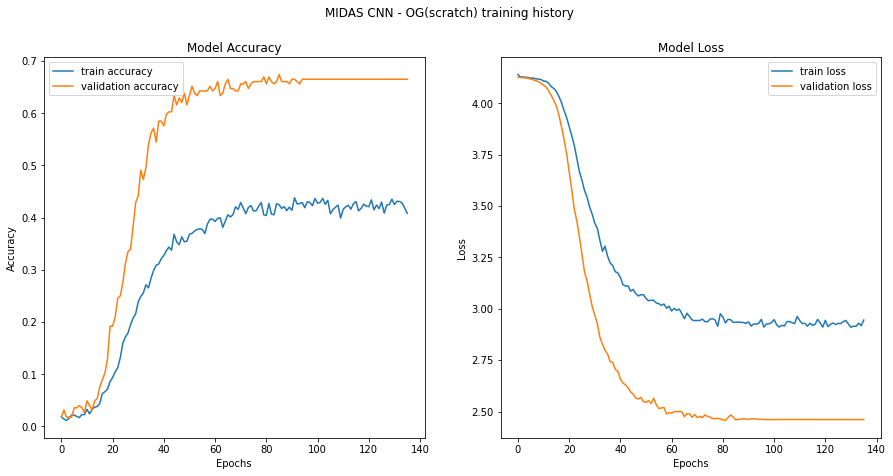

In [ ]:
task1_CNN.training_history(title='MIDAS CNN - OG(scratch) training history')

##### Convergence time Analysis:

Convergence time model took about 50 epochs when trained from scratch to reach the final accuracy levels. 

#### Visualizing the validation performance of the model

This should more or less be how the model should perform on a test set as the validation set is not used for training.

Visualizing the model's performance on the validation data-set.

Class labels
{'Sample001': 0, 'Sample002': 1, 'Sample003': 2, 'Sample004': 3, 'Sample005': 4, 'Sample006': 5, 'Sample007': 6, 'Sample008': 7, 'Sample009': 8, 'Sample010': 9, 'Sample011': 10, 'Sample012': 11, 'Sample013': 12, 'Sample014': 13, 'Sample015': 14, 'Sample016': 15, 'Sample017': 16, 'Sample018': 17, 'Sample019': 18, 'Sample020': 19, 'Sample021': 20, 'Sample022': 21, 'Sample023': 22, 'Sample024': 23, 'Sample025': 24, 'Sample026': 25, 'Sample027': 26, 'Sample028': 27, 'Sample029': 28, 'Sample030': 29, 'Sample031': 30, 'Sample032': 31, 'Sample033': 32, 'Sample034': 33, 'Sample035': 34, 'Sample036': 35, 'Sample037': 36, 'Sample038': 37, 'Sample039': 38, 'Sample040': 39, 'Sample041': 40, 'Sample042': 41, 'Sample043': 42, 'Sample044': 43, 'Sample045': 44, 'Sample046': 45, 'Sample047': 46, 'Sample048': 47, 'Sample049': 48, 'Sample050': 49, 'Sample051': 50, 'Sample052': 51, 'Sample053': 52, 'Sample054': 53, 'Sample055': 54, 'Sample056': 55, 'Sample057': 56, 'Sample058': 57, 'Sample059

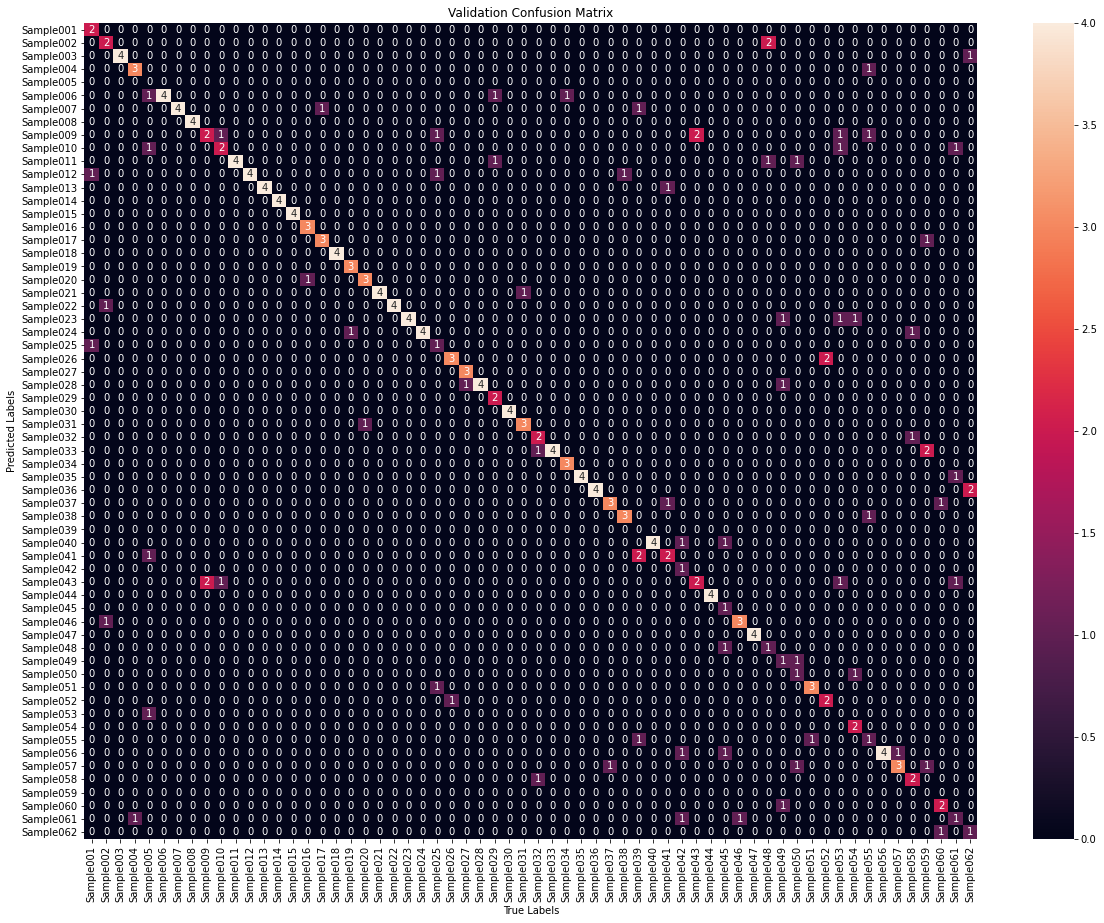

In [ ]:
task1_CNN.load_model()
task1_CNN.analyze_model(figsize=(20,15))

##### Analyzing the Model:

The accuracy of a model which will predict a class randomly should be *1/62 $\approx$ 1.62%* compare to that model's accuracy actually looks decent. The diagonal of the confusion matrix also looks decently swollen which is another sign that the model is trained decently on the given dataset. Despit a lot of possible confusion in the dataset such a small CNN's accuracy of ~67% (42% training accuracy) seems great. The validation set is fairly small so I will not be surprised if the test accuracy is smaller than validation accuracy but it should be somwhere in between training(possibly higher) and validation accuracy. I did inspect the dataset myself and there are a lot of small and captial letters mixed in different classes sample which will definetly confuse the model.

---

## 2. SUBTASK-2

### SUBTASK-2-A

Training the model on only first 10-classes of the dataset and then using this model to train on MNIST dataset. Re-iterating the steps in SUBTASK-1 for a model with 10-classes. Defining the set of parameters needed to train a model

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions.

In [ ]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-2-a.h5'
ES_PATIENCE = 30 # patience for early-stopping (in epochs)
'''
using a high early stopping crierion as the model is trained
from scratch and we do not want it to stop early
'''
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

#### Defining the model & generators (to load the images in batches for training)

Defining and compiling model-2-A for training (using default label-smmothing(0.1) of MIDAS-CNN because there is less chance of confusion among these classes)

In [ ]:
task2a_CNN = MIDAS_CNN()
task2a_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_34 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_35 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)              

Modifying the data-frame to only include data-points for $1^{st}$ - 10 classes *digits 0 to 9*.

Using this modified df to define generators

In [ ]:
# Using the same train and validation split as in SUBTASK-1
class_0_to_9 = ['Sample001', 'Sample002', 'Sample003', 'Sample004', 'Sample005',
                'Sample006', 'Sample007', 'Sample008', 'Sample009', 'Sample010',]
df = df[df['label'].isin(class_0_to_9)]
task2a_CNN.define_generators(BATCH_SIZE, df)

Found 360 validated image filenames belonging to 10 classes.
Found 40 validated image filenames belonging to 10 classes.


#### Training the model

Defining callbackas(same ones as before) and training the model.

In [ ]:
task2a_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
task2a_CNN.train(EPOCHS=EPOCHS)

Epoch 1/100
22/22 [==============================] - 6s 256ms/step - loss: 2.3531 - accuracy: 0.1211 - val_loss: 2.3145 - val_accuracy: 0.1250
Epoch 2/100
22/22 [==============================] - 5s 239ms/step - loss: 2.2998 - accuracy: 0.1057 - val_loss: 2.2943 - val_accuracy: 0.0312
Epoch 3/100
22/22 [==============================] - 5s 234ms/step - loss: 2.2964 - accuracy: 0.1140 - val_loss: 2.2838 - val_accuracy: 0.1250
Epoch 4/100
22/22 [==============================] - 5s 246ms/step - loss: 2.2793 - accuracy: 0.1414 - val_loss: 2.2788 - val_accuracy: 0.2500
Epoch 5/100
22/22 [==============================] - 5s 235ms/step - loss: 2.2822 - accuracy: 0.1475 - val_loss: 2.2751 - val_accuracy: 0.1250
Epoch 6/100
22/22 [==============================] - 5s 234ms/step - loss: 2.2640 - accuracy: 0.1871 - val_loss: 2.2510 - val_accuracy: 0.1875
Epoch 7/100
22/22 [==============================] - 5s 234ms/step - loss: 2.2512 - accuracy: 0.1647 - val_loss: 2.2218 - val_accuracy: 0.2188

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

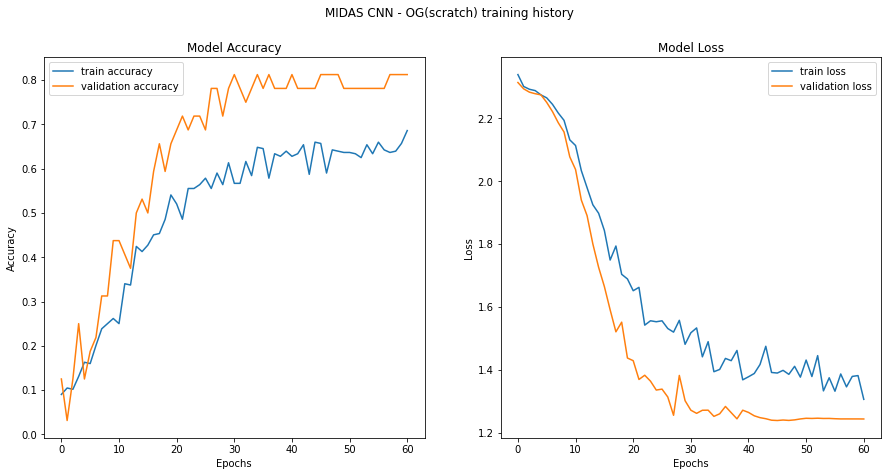

In [ ]:
task2a_CNN.training_history(title='MIDAS CNN - OG[0-9](scratch) training history')

#### Visualizing the validation performance of the model

This should more or less be how the model should perform on a test set as the validation set is not used for training.

Visualizing the model's performance on the validation data-set.

Class labels
{'Sample001': 0, 'Sample002': 1, 'Sample003': 2, 'Sample004': 3, 'Sample005': 4, 'Sample006': 5, 'Sample007': 6, 'Sample008': 7, 'Sample009': 8, 'Sample010': 9}


Class distribution in validation set
{0: 4, 1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4}


Validation Accuracy of the model is 82.50%


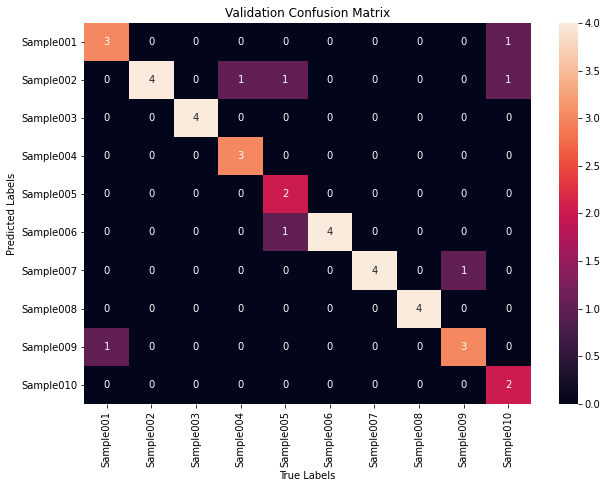

In [ ]:
task2a_CNN.load_model()
task2a_CNN.analyze_model(figsize=(10, 7))

The model has very good accuracy for training and validation dataset. I expect the model to have good accuracy on test set is well.

### SUBTASK-2-B

Transferring this model to MNIST dataset and analysing its result.

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

In [ ]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-2-b.h5'
ES_PATIENCE = 10 # patience for early-stopping (in epochs)
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

Compiling the model similiar to **SUBTASK-2-BA** to be able to load its weight and continue training from there (using default label-smmothing of 0.1 for MIDAS-CNN as there can be some confusion because of shift)

In [ ]:
task2b_CNN = MIDAS_CNN()
task2b_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_36 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_37 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 64)              

#### Loading the MNIST data-set

MNIST data is one of the data-sets avaialable in keras and we can directly download and load it from there.

Loading training and testing MNIST data for its standard split

In [ ]:
# We can directly load the MNIST dataset in keras 
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

####-----REF - https://keras.io/examples/vision/mnist_convnet/ -----####
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

#### Training the model (transfer-Learning from SUBTASK-2-A model)

Defining the callbacks and loading weights of model from **SUBTASK-2-A** to continue training from there (As asked in the task).

In [ ]:
# Training the model on the MNIST dataset

#Defining callbacks
task2b_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
# Loading the weights of task2a model in task2b for transfer-learning
task2b_CNN.load_model(os.path.join(MODEL_LOC, 'CNN-subtask-2-a.h5'))
# Training the model
task2b_CNN.train_x_y(x_train, y_train, BATCH_SIZE, EPOCHS, VALIDATION_SPLIT)

Epoch 1/100
1688/1688 [==============================] - 16s 9ms/step - loss: 1.4693 - accuracy: 0.6115 - val_loss: 0.7452 - val_accuracy: 0.9450
Epoch 2/100
1688/1688 [==============================] - 16s 10ms/step - loss: 1.0211 - accuracy: 0.8168 - val_loss: 0.6958 - val_accuracy: 0.9633
Epoch 3/100
1688/1688 [==============================] - 14s 8ms/step - loss: 0.9556 - accuracy: 0.8482 - val_loss: 0.6751 - val_accuracy: 0.9693
Epoch 4/100
1688/1688 [==============================] - 15s 9ms/step - loss: 0.9238 - accuracy: 0.8621 - val_loss: 0.6584 - val_accuracy: 0.9740
Epoch 5/100
1688/1688 [==============================] - 15s 9ms/step - loss: 0.9046 - accuracy: 0.8713 - val_loss: 0.6540 - val_accuracy: 0.9757
Epoch 6/100
1688/1688 [==============================] - 15s 9ms/step - loss: 0.8903 - accuracy: 0.8800 - val_loss: 0.6538 - val_accuracy: 0.9753
Epoch 7/100
1688/1688 [==============================] - 15s 9ms/step - loss: 0.8860 - accuracy: 0.8809 - val_loss: 0.6499 

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

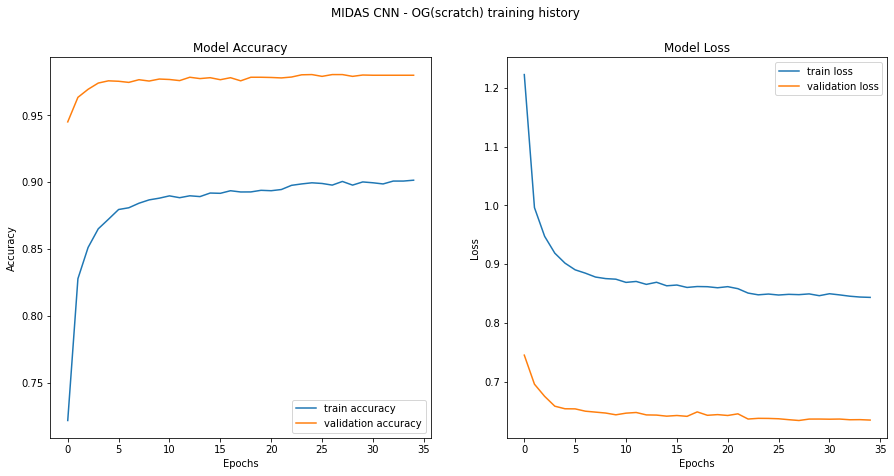

In [ ]:
task2b_CNN.training_history(title='MIDAS CNN - MNIST(TL) training history')

#### Visualizing the test performance of the model

Visualizing the model's performance on the MNIST test-set.

Class distribution in MNIST test set
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Test Accuracy of the model is 97.61%


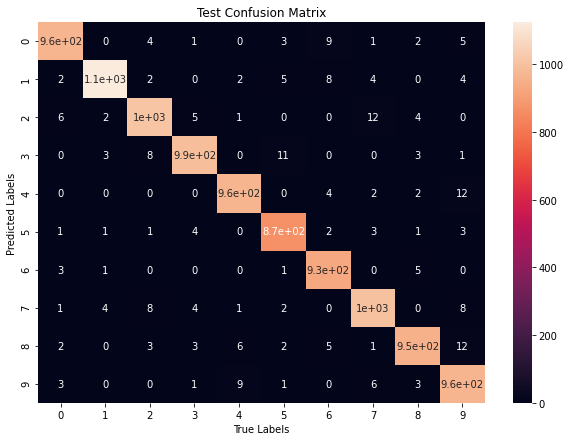

In [ ]:
task2b_CNN.load_model()
task2b_CNN.analyse_x_y(x_test, y_test)

Since the number of model paramters are considerably lower than the number of trainng samples. The model is definetly not overfitting and it has amazinf accuracy. 

### Comapring the convergence time

Training on OG data from scractch v/s training on MNIST data from model trained on OG data.(**OG**, refers to original) 

Abbreavation **TL**, refers to transfer learned or transfer learning  (depending on the context).

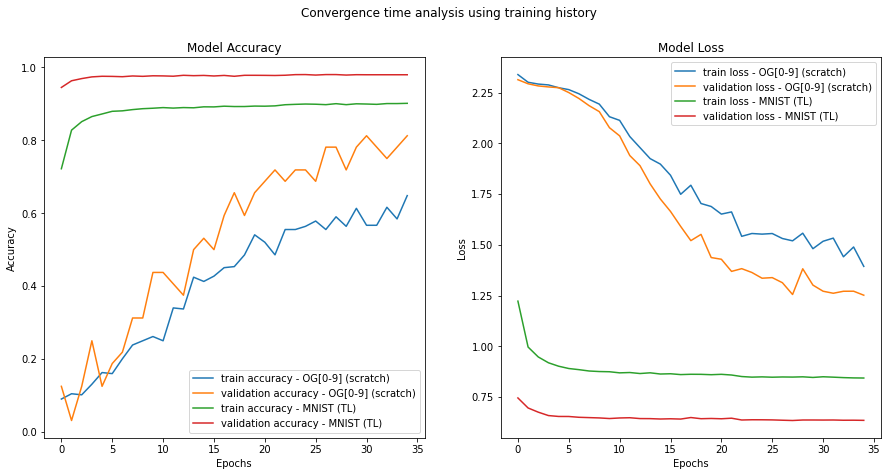

In [ ]:
# Taking out the training histories
train_history_og = task2a_CNN.return_training_history()
train_history_mnist = task2b_CNN.return_training_history()

epochs_in_both_training = min(len(train_history_mnist.history['loss']),
                              len(train_history_og.history['loss']))

# Plotting the training curve for epochs in both the training (from scracth on OG-data), (TL on MNIST-data)


fig = plt.figure(1, figsize=(15, 7))
axes = fig.add_subplot(1, 2, 1)
axes.plot(train_history_og.history['accuracy'][0:epochs_in_both_training], color='C0')
axes.plot(train_history_og.history['val_accuracy'][0:epochs_in_both_training], color='C1')
axes.plot(train_history_mnist.history['accuracy'][0:epochs_in_both_training], color='C2')
axes.plot(train_history_mnist.history['val_accuracy'][0:epochs_in_both_training], color='C3')
axes.set(xlabel='Epochs', ylabel='Accuracy', title='Model Accuracy')
axes.legend(['train accuracy - OG[0-9] (scratch)', 'validation accuracy - OG[0-9] (scratch)',
             'train accuracy - MNIST (TL)', 'validation accuracy - MNIST (TL)'])

axes = fig.add_subplot(1, 2, 2)
axes.plot(train_history_og.history['loss'][0:epochs_in_both_training], color='C0')
axes.plot(train_history_og.history['val_loss'][0:epochs_in_both_training], color='C1')
axes.plot(train_history_mnist.history['loss'][0:epochs_in_both_training], color='C2')
axes.plot(train_history_mnist.history['val_loss'][0:epochs_in_both_training], color='C3')
axes.set(xlabel='Epochs', ylabel='Loss', title='Model Loss')
axes.legend(['train loss - OG[0-9] (scratch)', 'validation loss - OG[0-9] (scratch)',
             'train loss - MNIST (TL)', 'validation loss - MNIST (TL)'])
plt.suptitle('Convergence time analysis using training history')
plt.show()

#### Conclusion on convergence time:

It is evident to see to see then when trained from scratch the model took fairly long number of epochs (*15-20 epochs*) to reach a steady final accuracy level. Whereas, when trained on the previously trained model on a similar dataset the model converges to the final accuracy evel fairly quickly (*5-epochs*).

This happens because the features to classify the MNIST data are fairly similar to the features learned to classify the given original data. This is the concept of Transfer Learning which not only reduces the convergnece time but also reduces the amount of data needed to train a network (you can **FINE-TUNE** a deep-model on a smaller dataset without overfitting). This is the case because the both the problems are the same and the features required by models to classify both the data-sets are very similar. If that was not the case and say we needed a totally different feature to classify the second data-set, then the initial weights learned from OG-dataset would have performed behaved like a random weight.  

---

## 3. SUBTASK-3

The data-set given to train the model for this tasks seems jumbed to with only the class for which the folder is labeled being missing from the image set. What I mean by this is that the folder for class `0` has all images of all the digits other than `0`. It's more like dataset for `!0`. We can still use this dataset to train a model to identify the image which doesn't look similar to any image in the data-set.  

### Visualizing the data distribution of data-set given for SUBTASK-3

Number of classes in the dataset are 10
Total number of images in the dataset is 60000


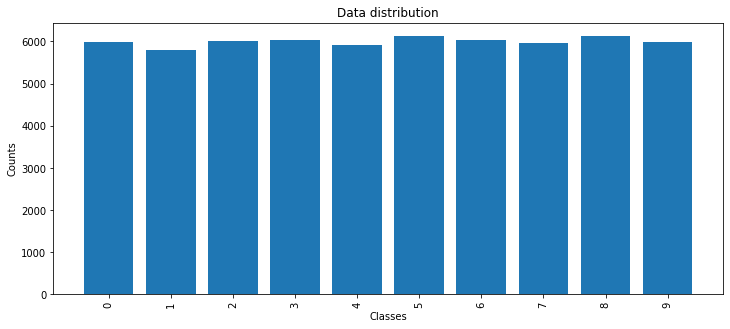

In [ ]:
root_dir = './mnistTask3/mnistTask'
classes = os.listdir(root_dir)

print(f'Number of classes in the dataset are {len(classes)}')

counts = []
for class_ in classes:
    counts.append(len(os.listdir(os.path.join(root_dir, class_))))
                  
print(f'Total number of images in the dataset is {sum(counts)}')

plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.title('Data distribution')

plt.show()

It is evident that this dataset has more images compare to the dataset given for **SUBTASK-1**

### SUBTASK-3-A

Transfer learning the **SUBTASK-2-A** model to the **SUBTASK-3** dataset.

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

In [ ]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-3-a.h5'
ES_PATIENCE = 10 # patience for early-stopping (in epochs)
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

#### Defining the model & generators (to load the images in batches for training)

Defining the model and compiling it similar to **SUBTASK-2-A** to be able to transfer-learn from that model. Using a high label-smoothing as the classes are very noisy

In [ ]:
task3a_CNN = MIDAS_CNN()
task3a_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR, label_smoothing=0.4)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_38 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_39 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 64)              

Defining a dataframe with all the datapoints for sub-task 3 and using it to define generators for training the model

In [ ]:
df = pd.DataFrame()
imgs = []
imgs_class = []
for class_ in classes:
    # for images in a class 
    for i in range(len(os.listdir(os.path.join(root_dir, class_)))):
        imgs.append(os.path.join(root_dir, class_,
                                 os.listdir(os.path.join(root_dir, class_))[i]))
        imgs_class.append(class_)

df['imgs'] = imgs
df['label'] = imgs_class
task3a_CNN.define_generators(BATCH_SIZE, df)

Found 54000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


#### Training the model (Transfer learning of SUBTASK-2-A model)

Defining callbacks and training (transfer learning off of **SUBTASK-2-A**) the model.

In [ ]:
task3a_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
# Loading the weights of task2a model in task2b for transfer-learning
task3a_CNN.load_model(os.path.join(MODEL_LOC, 'CNN-subtask-2-a.h5'))
task3a_CNN.train(EPOCHS=EPOCHS)

Epoch 1/100
1687/1687 [==============================] - 52s 30ms/step - loss: 2.3519 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1001
Epoch 2/100
1687/1687 [==============================] - 52s 31ms/step - loss: 2.3029 - accuracy: 0.1006 - val_loss: 2.3027 - val_accuracy: 0.1021
Epoch 3/100
1687/1687 [==============================] - 49s 29ms/step - loss: 2.3028 - accuracy: 0.1007 - val_loss: 2.3028 - val_accuracy: 0.1021
Epoch 4/100
1687/1687 [==============================] - 49s 29ms/step - loss: 2.3028 - accuracy: 0.1005 - val_loss: 2.3027 - val_accuracy: 0.0994
Epoch 5/100
1687/1687 [==============================] - 49s 29ms/step - loss: 2.3028 - accuracy: 0.1015 - val_loss: 2.3031 - val_accuracy: 0.1024
Epoch 6/100
1687/1687 [==============================] - 49s 29ms/step - loss: 2.3029 - accuracy: 0.1009 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 7/100
1687/1687 [==============================] - 50s 29ms/step - loss: 2.3028 - accuracy: 0.0984 - val_loss: 2

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

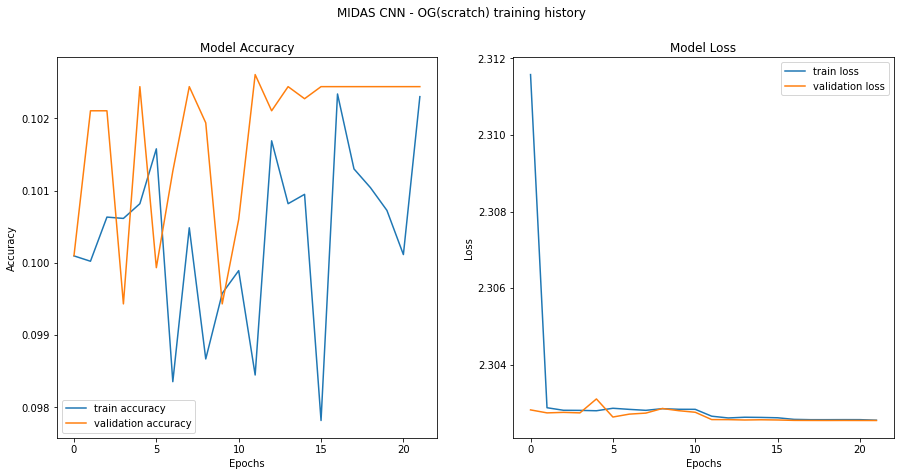

In [ ]:
task3a_CNN.training_history(title='MIDAS CNN - OG-3(TL - SUBTASK-2-A) training history')

#### Visualizing the test performance of the model on the MNIST test set

Visualizing the model's performance on the **MNIST test-set**

Class distribution in MNIST test set
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Test Accuracy of the model is 9.06%


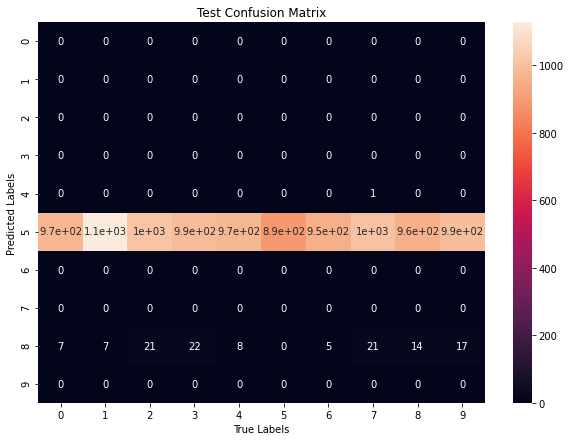

In [ ]:
task3a_CNN.load_model()
task3a_CNN.analyse_x_y(x_test, y_test)

Accuracy of this model is as good as that of a `random model` (**10%**) which is expected since the data is so nosiy. Each labels have images from other classes which should make the model not learn anythin about the class. The good part is that the model is not overfitting which is very much possible if the model becomes deep and has parameters much more than 120k, which is not the case.

## SUBTASK-3-B

Training from scratch Traing the CNN model from **scratch** on the data-set given for sub-task 3.

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

In [ ]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-3-b.h5'
ES_PATIENCE = 10 # patience for early-stopping (in epochs)
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

#### Defining the model & generators (to load the images in batches for training)

Defining the model and compiling it. Using a high label-smoothing as the classes are very noisy

In [ ]:
task3b_CNN = MIDAS_CNN()
task3b_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR, label_smoothing=0.4)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_40 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_41 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 64)              

Using dataframe sor sub-task 3-A the datapoints for sub-task 3 and using it to define generators for training the model

In [ ]:
task3b_CNN.define_generators(BATCH_SIZE, df)

Found 54000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


#### Training the model 

Defining callbacks and training (transfer learning off of SUBTASK-2-A) the model.

In [ ]:
task3b_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
task3b_CNN.train(EPOCHS=EPOCHS)

Epoch 1/100
1687/1687 [==============================] - 53s 31ms/step - loss: 2.3044 - accuracy: 0.1034 - val_loss: 2.3025 - val_accuracy: 0.1034
Epoch 2/100
1687/1687 [==============================] - 51s 30ms/step - loss: 2.3026 - accuracy: 0.1038 - val_loss: 2.3025 - val_accuracy: 0.1128
Epoch 3/100
1687/1687 [==============================] - 51s 30ms/step - loss: 2.3027 - accuracy: 0.1025 - val_loss: 2.3020 - val_accuracy: 0.1016
Epoch 4/100
1687/1687 [==============================] - 52s 31ms/step - loss: 2.3026 - accuracy: 0.1044 - val_loss: 2.3016 - val_accuracy: 0.1128
Epoch 5/100
1687/1687 [==============================] - 53s 32ms/step - loss: 2.3023 - accuracy: 0.1049 - val_loss: 2.3019 - val_accuracy: 0.1080
Epoch 6/100
1687/1687 [==============================] - 54s 32ms/step - loss: 2.3021 - accuracy: 0.1049 - val_loss: 2.3013 - val_accuracy: 0.1100
Epoch 7/100
1687/1687 [==============================] - 51s 30ms/step - loss: 2.3017 - accuracy: 0.1108 - val_loss: 2

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

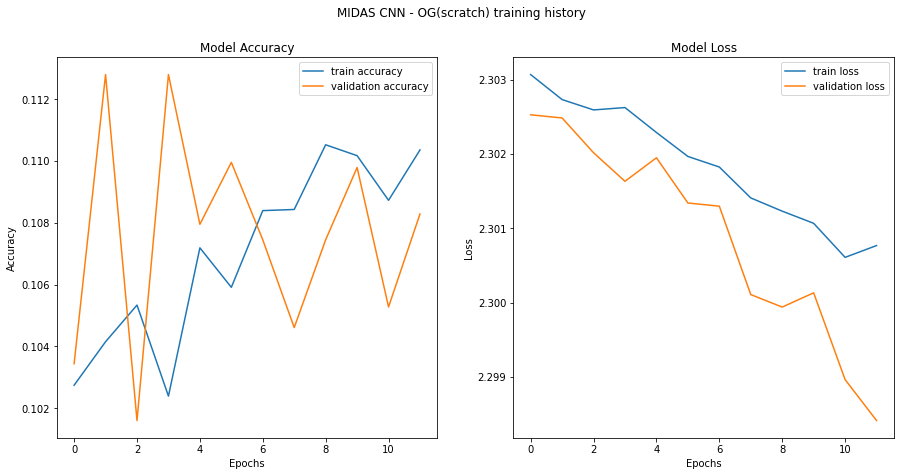

In [ ]:
task3b_CNN.training_history(title='MIDAS CNN - OG-3(scratch) training history')

#### Visualizing the test performance of the model on the MNIST test set

Visualizing the model's performance on the **MNIST test-set**

Class distribution in MNIST test set
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Test Accuracy of the model is 4.62%


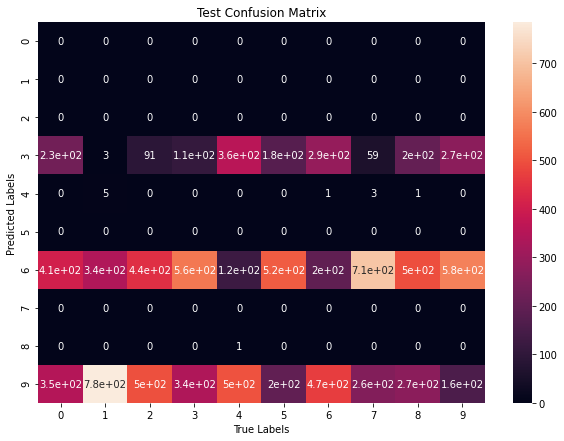

In [ ]:
task3b_CNN.load_model()
task3b_CNN.analyse_x_y(x_test, y_test)

We don't see any drastic difference in the convergence time for thraining from scratch as the model is not learning anything. Infact it is worse than a `random model` (**10%**). So to not learn anything model should take the same more-or-less the same time strating from any set of weights.

## SUBTASK-3-C

Training the CNN on data-set for SUBTASK-3 using weights from **SUBTASK-1**.

Definig the basic set of parameters needed to define an object of class MIDAS-CNN objects and call its functions

In [ ]:
N_CLASSES = 10
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-3-c.h5'
ES_PATIENCE = 10 # patience for early-stopping (in epochs)
LR_PATIENCE=5 # patience to reduce the learning rate (in epochs)
LR_REDUCTION_FACTOR = 0.2
INITIAL_LR = 0.01
EPOCHS=100

#### Defining the model & generators (to load the images in batches for training)

Defining the model and compiling it similar to **SUBTASK-1**. Using a high label-smoothing as the classes are very noisy

In [ ]:
task3c_CNN = MIDAS_CNN()
# Using the weights of task-1 model as transfer-learning from then to the SUBTASK-3 dataset 
task3c_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR,
                       label_smoothing=0.4, og_model=task1_CNN.return_model())

Original Model Transformed successfully
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
activation_32 (Activation)   (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_33 (Activation)   (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_33 (M

Using dataframe sor sub-task 3-A the datapoints for sub-task 3 and using it to define generators for training the model

In [ ]:
task3c_CNN.define_generators(BATCH_SIZE, df)

Found 54000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


#### Training the model

Defining callbacks and training (transfer learning off of SUBTASK-2-A) the model.

In [ ]:
task3c_CNN.define_callbacks(ES_PATIENCE, LR_PATIENCE, MODEL_WTS_FILE_NAME)
task3c_CNN.train(EPOCHS=EPOCHS)

Epoch 1/100
1687/1687 [==============================] - 79s 47ms/step - loss: 2.3063 - accuracy: 0.1002 - val_loss: 2.3028 - val_accuracy: 0.1021
Epoch 2/100
1687/1687 [==============================] - 63s 37ms/step - loss: 2.3028 - accuracy: 0.1017 - val_loss: 2.3028 - val_accuracy: 0.1024
Epoch 3/100
1687/1687 [==============================] - 64s 38ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3028 - val_accuracy: 0.0991
Epoch 4/100
1687/1687 [==============================] - 64s 38ms/step - loss: 2.3029 - accuracy: 0.1007 - val_loss: 2.3025 - val_accuracy: 0.1066
Epoch 5/100
1687/1687 [==============================] - 64s 38ms/step - loss: 2.3029 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1023
Epoch 6/100
1687/1687 [==============================] - 111s 66ms/step - loss: 2.3028 - accuracy: 0.0999 - val_loss: 2.3027 - val_accuracy: 0.0993
Epoch 7/100
1687/1687 [==============================] - 144s 85ms/step - loss: 2.3028 - accuracy: 0.1020 - val_loss:

#### Visualizing the training history

Visualizing the training history (not using tensor-board to keep the code nice and clean)

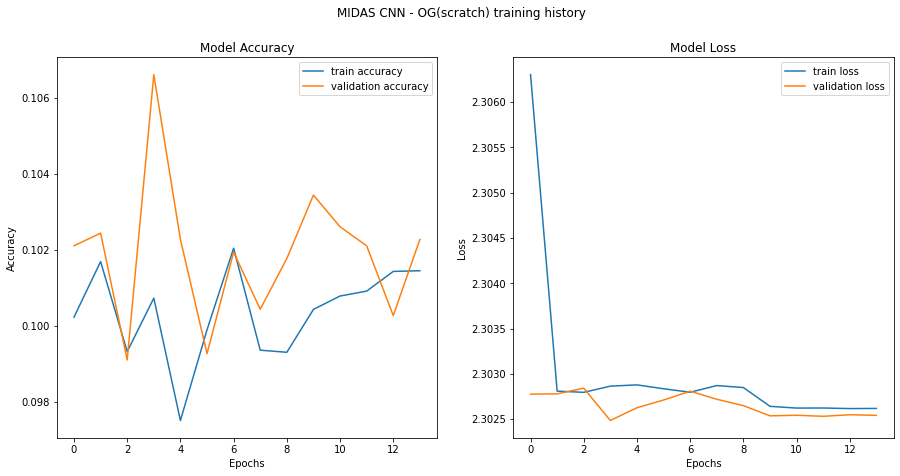

In [ ]:
task3c_CNN.training_history(title='MIDAS CNN - OG-3(scratch) training history')

#### Visualizing the test performance of the model on the MNIST test set

Visualizing the model's performance on the MNIST test-set

Class distribution in MNIST test set
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Test Accuracy of the model is 6.67%


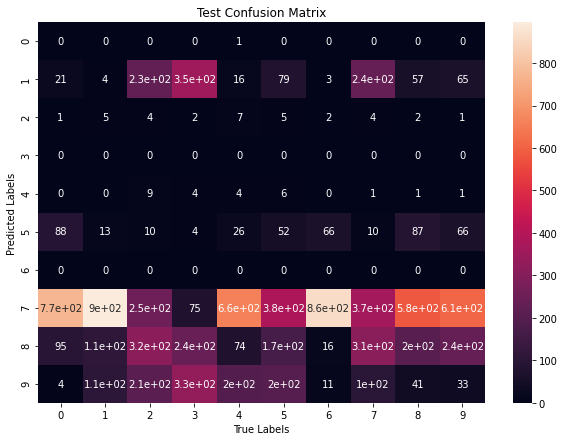

In [ ]:
task3c_CNN.load_model()
task3c_CNN.analyse_x_y(x_test, y_test)

Again we don't see any drastic difference in the convergence time for thraining from scratch as the model is not learning anything. Infact it is worse than a `random model` (**10%**). So to not learn anything model should take the same more-or-less the same time strating from any set of weights.

#### Visualizing the consistency of convergence time for the models ( *random-model / no-learning*)

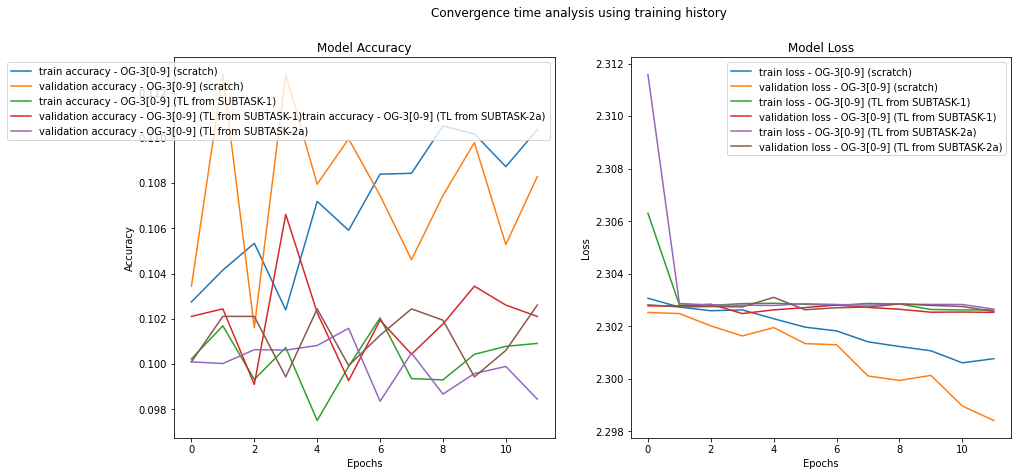

In [ ]:
# Taking out the training histories
train_history_2a = task3a_CNN.return_training_history()
train_history_scratch = task3b_CNN.return_training_history()
train_history_1 = task3c_CNN.return_training_history()

epochs_in_both_training = min(len(train_history_scratch.history['loss']),
                              len(train_history_1.history['loss']),
                              len(train_history_2a.history['loss']))

# Plotting the training curve for epochs in both the training (from scracth on OG-data), (TL on MNIST-data)


fig = plt.figure(1, figsize=(15, 7))
axes = fig.add_subplot(1, 2, 1)
axes.plot(train_history_scratch.history['accuracy'][0:epochs_in_both_training], color='C0')
axes.plot(train_history_scratch.history['val_accuracy'][0:epochs_in_both_training], color='C1')
axes.plot(train_history_1.history['accuracy'][0:epochs_in_both_training], color='C2')
axes.plot(train_history_1.history['val_accuracy'][0:epochs_in_both_training], color='C3')
axes.plot(train_history_2a.history['accuracy'][0:epochs_in_both_training], color='C4')
axes.plot(train_history_2a.history['val_accuracy'][0:epochs_in_both_training], color='C5')
axes.set(xlabel='Epochs', ylabel='Accuracy', title='Model Accuracy')
axes.legend(['train accuracy - OG-3[0-9] (scratch)', 'validation accuracy - OG-3[0-9] (scratch)',
             'train accuracy - OG-3[0-9] (TL from SUBTASK-1)',
             'validation accuracy - OG-3[0-9] (TL from SUBTASK-1)'
             'train accuracy - OG-3[0-9] (TL from SUBTASK-2a)',
             'validation accuracy - OG-3[0-9] (TL from SUBTASK-2a)'])

axes = fig.add_subplot(1, 2, 2)
axes.plot(train_history_scratch.history['loss'][0:epochs_in_both_training], color='C0')
axes.plot(train_history_scratch.history['val_loss'][0:epochs_in_both_training], color='C1')
axes.plot(train_history_1.history['loss'][0:epochs_in_both_training], color='C2')
axes.plot(train_history_1.history['val_loss'][0:epochs_in_both_training], color='C3')
axes.plot(train_history_2a.history['loss'][0:epochs_in_both_training], color='C4')
axes.plot(train_history_2a.history['val_loss'][0:epochs_in_both_training], color='C5')
axes.set(xlabel='Epochs', ylabel='Loss', title='Model Loss')
axes.legend(['train loss - OG-3[0-9] (scratch)', 'validation loss - OG-3[0-9] (scratch)',
             'train loss - OG-3[0-9] (TL from SUBTASK-1)',
             'validation loss - OG-3[0-9] (TL from SUBTASK-1)',
             'train loss - OG-3[0-9] (TL from SUBTASK-2a)',
             'validation loss - OG-3[0-9] (TL from SUBTASK-2a)'
            ])
plt.suptitle('Convergence time analysis using training history')
plt.show()

We can see that there is not a lot of difference in converngence time wither while training from scratch or training from weights of another model trained on a similar data-set. 

---

## Qualitative Analysis of the SUBSET-3 dataset

It is evidently visible that the data-set is extremly noisy and the model is not able to learn anything even with a label-smoothing of `0.4`. I do think that the class `0` has images of all the class other than `0` and class `1` has images of all the classes other than `1` and the same is the case for other classes is well.

If this is indeed the fact then I should just use the models trained before and save encoded-features of all the image in a class and while predicting predict the class which has maximum of minimum distance L2-distance/similarity(*cosine*) to any feature in the training set (reverse clustering since the class is `!0`).


---
## Testing the functions to predict on any given dataset


### 1. Format-A, predict on a single image.

Defining parameters to define an `object` to be used for prediction only. Therefore not defining training parameters. 

In [ ]:
N_CLASSES = 62
MODEL_INPUT_SIZE = (28, 28, 1) 
INPUT_SIZE = (28, 28)
BATCH_SIZE = 16

#Training specific parameters
MODEL_LOC = './models'
MODEL_WTS_FILE_NAME = 'CNN-subtask-1.h5'
INITIAL_LR = 0.01

##### compiling the model

Basic model for prediction on an image.

In [ ]:
task1_CNN = MIDAS_CNN()
task1_CNN.compile_CNN(MODEL_INPUT_SIZE, N_CLASSES, INITIAL_LR, label_smoothing=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

##### Loading the model

Essential for testing to be valid load the model with the best weights obtained during the training cycle.

In [ ]:
task1_CNN.load_model(model_loc=os.path.join(MODEL_LOC, MODEL_WTS_FILE_NAME))

#### Predicting on an image

Selecting an image to predict on

In [ ]:
img_loc = os.path.join('train', 'Sample056', 'img056-002.png')

#### Making predictions on that image

(1, 28, 28, 1)
Model predicts train\Sample056\img056-002.png to be belonging to class 55


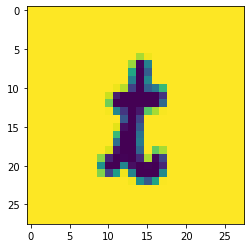

In [ ]:
probability, class_ = task1_CNN.predict_img(img_loc)
print(f'Model predicts {img_loc} to be belonging to class {class_}')

In [ ]:
print(f'Prediction probability distribution of the image above is {probability}')

Prediction probability distribution of the image above is [0.00387058 0.00768369 0.0430079  0.00635199 0.03674888 0.00984596
 0.01053133 0.01175089 0.01944904 0.00557176 0.03362862 0.00984396
 0.0040358  0.01040686 0.01053794 0.00597764 0.01149336 0.00244753
 0.01990769 0.00730436 0.00801499 0.00241267 0.00630468 0.01338619
 0.00960015 0.00421642 0.02193302 0.01223366 0.00513784 0.00185495
 0.00167431 0.00182127 0.01125113 0.02496471 0.00668984 0.03035287
 0.03285252 0.00597018 0.01045122 0.05415294 0.01333    0.0387806
 0.02262254 0.01705359 0.01146272 0.0179272  0.02096737 0.02905501
 0.00632128 0.01151244 0.01538054 0.01869934 0.01681951 0.02627977
 0.02095767 0.07717236 0.01179185 0.00274761 0.00723059 0.03168426
 0.01601265 0.03051972]


#### Predicting using generator on a data in format similar to the training data

test-data provided by MIDAS is to be present in the location where the notebook is.

Found 930 images belonging to 62 classes.


C:\Users\verma\anaconda3\envs\anshul\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Class labels
{'Sample001': 0, 'Sample002': 1, 'Sample003': 2, 'Sample004': 3, 'Sample005': 4, 'Sample006': 5, 'Sample007': 6, 'Sample008': 7, 'Sample009': 8, 'Sample010': 9, 'Sample011': 10, 'Sample012': 11, 'Sample013': 12, 'Sample014': 13, 'Sample015': 14, 'Sample016': 15, 'Sample017': 16, 'Sample018': 17, 'Sample019': 18, 'Sample020': 19, 'Sample021': 20, 'Sample022': 21, 'Sample023': 22, 'Sample024': 23, 'Sample025': 24, 'Sample026': 25, 'Sample027': 26, 'Sample028': 27, 'Sample029': 28, 'Sample030': 29, 'Sample031': 30, 'Sample032': 31, 'Sample033': 32, 'Sample034': 33, 'Sample035': 34, 'Sample036': 35, 'Sample037': 36, 'Sample038': 37, 'Sample039': 38, 'Sample040': 39, 'Sample041': 40, 'Sample042': 41, 'Sample043': 42, 'Sample044': 43, 'Sample045': 44, 'Sample046': 45, 'Sample047': 46, 'Sample048': 47, 'Sample049': 48, 'Sample050': 49, 'Sample051': 50, 'Sample052': 51, 'Sample053': 52, 'Sample054': 53, 'Sample055': 54, 'Sample056': 55, 'Sample057': 56, 'Sample058': 57, 'Sample059

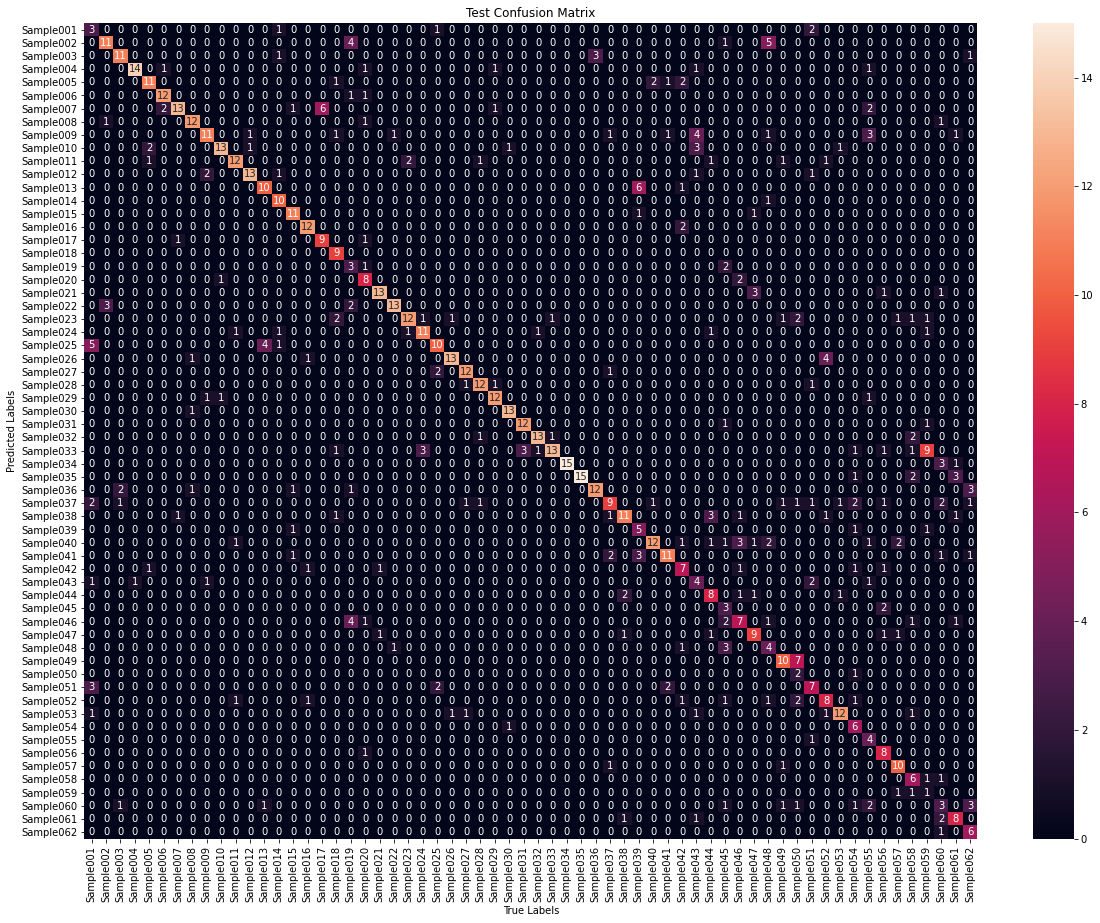

In [ ]:
acc = task1_CNN.test_format1(test_data_loc='test')

#### Predicting using generator on a data in format similar to the kaggle test-set (all images in a directory)

Dummy considering a class of the training data to be test-data.

In [ ]:
df = task1_CNN.test_format2(test_data_loc=os.path.join('train', 'Sample022'))
# Seeing the dataframe with predictions
df

Found 40 validated image filenames.


,image,dummy_class,probability,label
0,img022-001.png,,"[0.009983344, 0.040664673, 0.009649159, 0.0004...",21
1,img022-002.png,,"[0.0035758798, 0.047020737, 0.003864533, 5.549...",21
2,img022-003.png,,"[0.0039585857, 0.07604943, 0.0009091189, 0.000...",21
3,img022-005.png,,"[0.0018337002, 0.13498421, 0.00083003525, 0.00...",21
4,img022-006.png,,"[0.0026542004, 0.038337797, 0.006259151, 0.000...",21
5,img022-007.png,,"[0.004712679, 0.012739037, 0.024561407, 0.0008...",39
6,img022-008.png,,"[0.0012330071, 0.023712166, 0.0048957905, 0.00...",37
7,img022-009.png,,"[0.0068830056, 0.06277302, 0.0037918428, 0.000...",21
8,img022-010.png,,"[0.0032716107, 0.024018375, 0.0052936426, 0.00...",21
9,img022-011.png,,"[0.00666113, 0.12340533, 0.0017262283, 0.00114...",21


In [ ]:
df.to_csv('submission.csv', index=False)

In [ ]:
#END